In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [6]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

データの読み込み

GPUで作ったPickleのファイルは，CPUではそのままでは使えないため，工夫が必要．

https://www.kunita-gamefactory.com/post/%E3%80%90pytorch%E3%80%91gpu%E3%81%A7%E8%A8%93%E7%B7%B4%E3%81%95%E3%81%9B%E3%81%9F%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92cpu%E3%81%A7%E8%AA%AD%E3%81%BF%E8%BE%BC%E3%82%82%E3%81%86%E3%81%A8%E3%81%97%E3%81%9F%E3%81%8A%E8%A9%B1

を真似したらうまくCPU上でもファイルを読み込むことができるようになった．

In [7]:
import io
        
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [8]:
# ファイルの相対パスを指定
file_path = 'data_storage/Ising_samp_data_L16.pkl'

if torch.cuda.is_available():
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file, encoding='latin1')
else:
    with open(file_path, 'rb') as file:
        loaded_data = CPU_Unpickler(file).load()
        
# 読み込んだデータを個々の変数に分割
spin_data, temp_data = loaded_data

In [9]:
# データの形を確認
spin_data.shape , len(temp_data)

(torch.Size([25000, 16, 16]), 25000)

In [10]:
print(spin_data[10000], temp_data[10000])

tensor([[-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
         -1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
          1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
          1., -1.],
        [-1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
          1.,  1.],
        [-1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
         -1.,  1.],
        [-1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
         -1.,  1.],
        [ 1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
          1.,  1.],
        [-1., -1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
          1.,  1.],
        [ 

In [11]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, temp_train, temp_test = train_test_split(spin_data, temp_data, test_size=0.5)

In [12]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
temp_train = torch.tensor(temp_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
temp_test = torch.tensor(temp_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

C:\Users\sugay\AppData\Local\Temp\ipykernel_15076\3927323180.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\sugay\AppData\Local\Temp\ipykernel_15076\3927323180.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)


In [13]:
spin_train[1]

tensor([[-1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
         -1., -1.],
        [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,
         -1.,  1.],
        [ 1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
         -1.,  1.],
        [ 1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
         -1., -1.],
        [-1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,
         -1., -1.],
        [-

In [14]:
temp_train[1]

tensor([2.5000])

正解データはone-hot表現にする必要がある

In [15]:
# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# temp_train,temp_testをone-hotベクトルに変換
one_hot_temp_train = to_one_hot(temp_train, num_classes=25)
one_hot_temp_test = to_one_hot(temp_test, num_classes=25)

In [16]:
one_hot_temp_train[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [17]:
temp_train[0]

tensor([4.])

In [18]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_temp_train)
test_dataset = TensorDataset(spin_test, one_hot_temp_test)

In [19]:
train_dataset[0]

(tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
          -1., -1.],
         [-1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
          -1., -1.],
         [-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
          -1., -1.],
         [-1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
           1.,  1.],
         [-1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
          -1.,  1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
          -1.,  1.],
         [-1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
          -1.,  1.],
         [-1., -1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
           1.,  1.],
         [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,
           1., -1.],
         [-1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
          -

In [20]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [21]:
transformed_train_dataset[0]

(tensor([[-1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.],
         [-1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
           1., -1.],
         [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
          -1., -1.],
         [ 1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
          -1., -1.],
         [ 1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
          -1., -1.],
         [ 1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
          -1., -1.],
         [ 1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
          -1., -1.],
         [ 1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
          -1., -1.],
         [-1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
          -1., -1.],
         [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
           

In [22]:
# dataset内のテンソルを1次元化
transformed_train_dataset = [(sample[0].view(-1), sample[1]) for sample in transformed_train_dataset]
transformed_test_dataset = [(sample[0].view(-1), sample[1]) for sample in transformed_test_dataset]

In [23]:
transformed_train_dataset[0]

(tensor([-1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
          1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
          1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
         -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
         -1., -1., -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,
          1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
         -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
          1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
         -1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,
          1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         -1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
         -1., -1., -1.,  1., -1.,  1., -1., -1.,  1.

In [24]:
# DataLoaderの設定（バッチサイズ12500）
train_loader = DataLoader(transformed_train_dataset, batch_size=125, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=125)

In [25]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([125, 256]), torch.Size([125, 25]))

モデルの定義

In [26]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

モデルのインスタンス化

In [27]:
input_size = 16*16
hidden_size = 100
output_size = 25
model = FCNN(input_size, hidden_size, output_size)
model.to(device)
# モデルの概要表示
print(model)

FCNN(
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=25, bias=True)
)


損失関数と最適化アルゴリズムの設定

In [28]:
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)     # Adam,L2正則化

学習の実行

In [29]:
num_epochs = 100
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # 正解数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 3.203599557876587, acc: 0.05671998858451843, test loss: 3.200340371131897, test acc: 0.06407999247312546
epoch: 1, loss: 3.1932980465888976, acc: 0.0960799902677536, test loss: 3.1921865200996398, test acc: 0.0772000104188919
epoch: 2, loss: 3.179581003189087, acc: 0.12088002264499664, test loss: 3.1839531373977663, test acc: 0.08799999952316284
epoch: 3, loss: 3.159657497406006, acc: 0.14312000572681427, test loss: 3.1785089921951295, test acc: 0.11184000223875046
epoch: 4, loss: 3.1384860563278196, acc: 0.16679997742176056, test loss: 3.1741175293922423, test acc: 0.10808000713586807
epoch: 5, loss: 3.1186337804794313, acc: 0.1940000206232071, test loss: 3.1720992636680605, test acc: 0.11048002541065216
epoch: 6, loss: 3.1032563138008116, acc: 0.20152001082897186, test loss: 3.169665162563324, test acc: 0.11343999952077866
epoch: 7, loss: 3.090530962944031, acc: 0.2187199741601944, test loss: 3.1690893006324767, test acc: 0.11176005005836487
epoch: 8, loss: 3.07942243

損失関数と正解率のグラフの作成

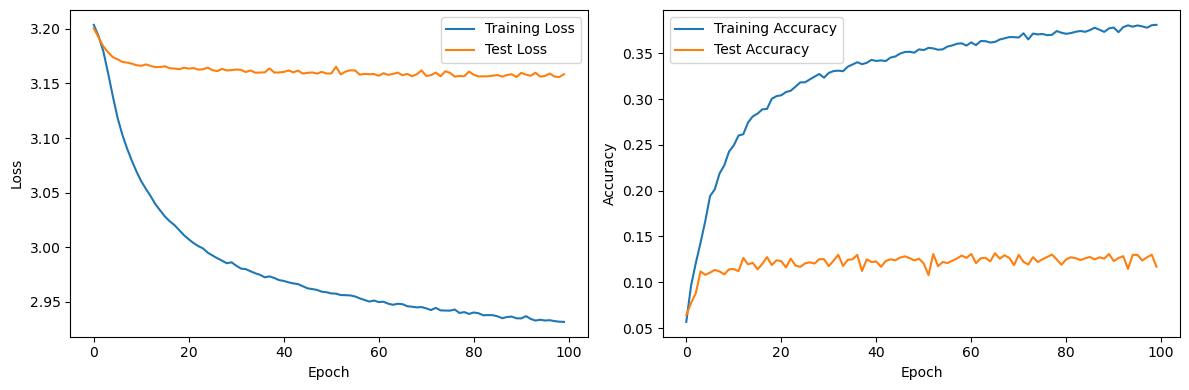

In [30]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [31]:
print(test_pred[:100])

tensor([17, 10,  7,  7,  7, 13,  1,  1,  7, 19,  7, 19, 19, 21, 23,  2, 19, 13,
        13, 19,  7,  0, 18, 18,  9, 10, 16, 21, 22,  7,  7, 21,  8, 14, 10, 23,
        14, 14, 19,  9, 18, 18, 24, 23, 10, 21, 18, 21, 18,  2, 10, 22, 21,  9,
        17, 24,  7, 10, 21, 16,  7,  1, 18, 24, 13,  0,  2, 16,  0, 16, 23,  7,
        16, 14,  7,  9,  7, 10,  7,  7,  7,  7, 23,  7, 23, 16, 19, 17, 14,  7,
        22,  7,  9,  0,  7,  7, 10,  7, 23,  1])


In [32]:
print(test_targets[:100])

tensor([21, 14,  5,  8,  6, 23,  3,  1,  1, 15,  6, 12, 13, 12, 18,  0, 23, 22,
        18, 18,  2,  3, 11, 20, 12, 10, 17, 18, 13,  0,  3, 14, 12, 11, 24, 20,
        11, 16, 12,  8, 16, 23, 13, 24, 14, 18, 19, 14, 14,  1, 11, 23, 19, 13,
        20, 15,  7, 10, 12, 20,  1, 11, 13, 11, 17,  5,  0, 17,  1, 11, 20,  0,
        14,  9,  6, 10,  2, 11,  1,  6,  7,  4, 18,  0, 13, 17, 21, 19, 16,  1,
        22,  5,  9,  1,  8,  8, 12,  9, 12,  9])


In [33]:
test_output.shape

torch.Size([125, 25])

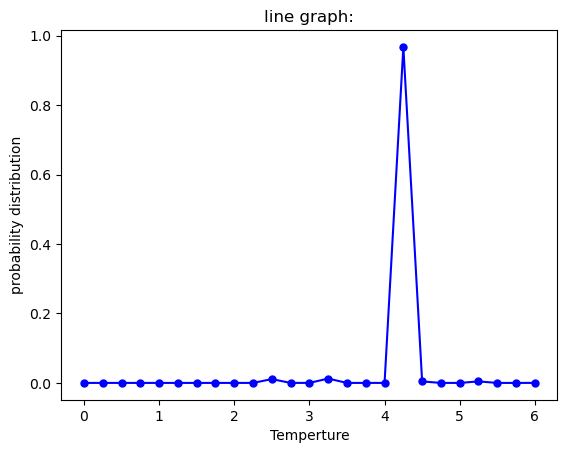

tensor(5.2500)


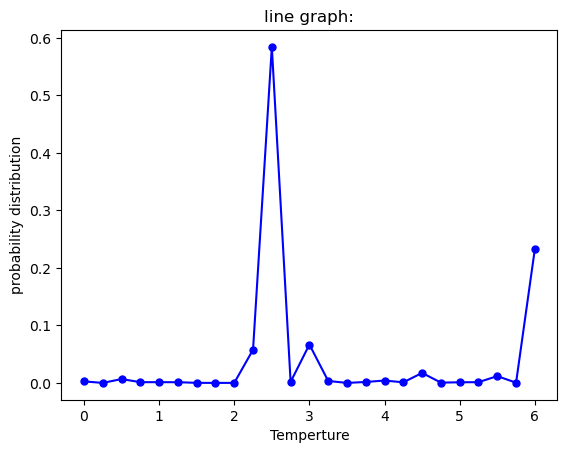

tensor(3.5000)


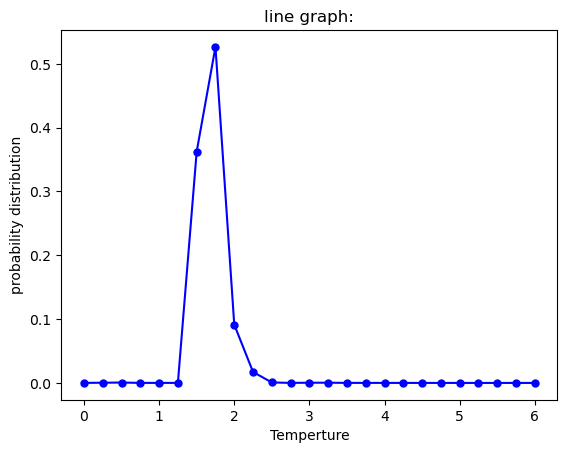

tensor(1.2500)


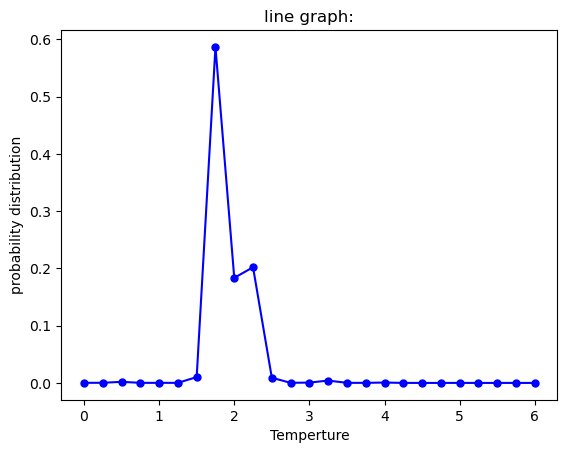

tensor(2.)


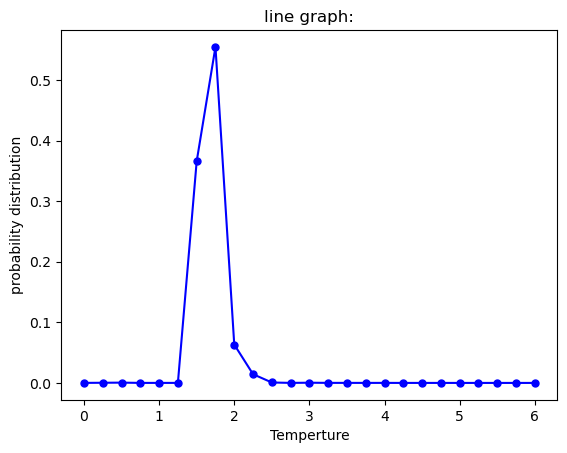

tensor(1.5000)


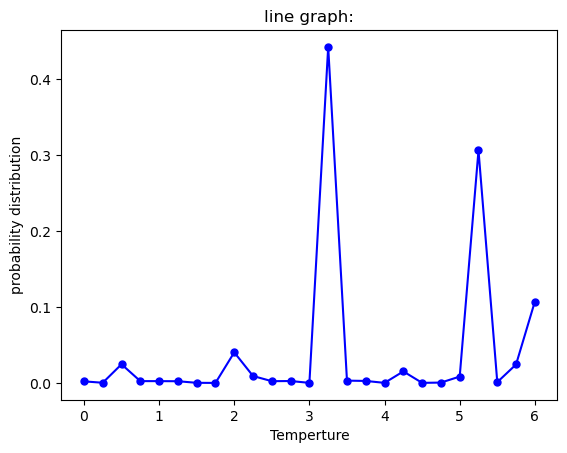

tensor(5.7500)


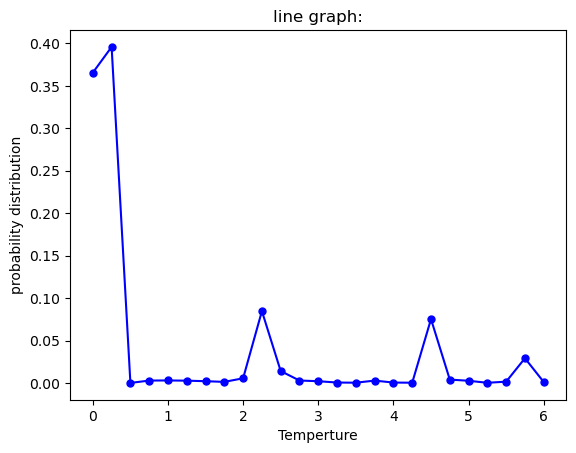

tensor(0.7500)


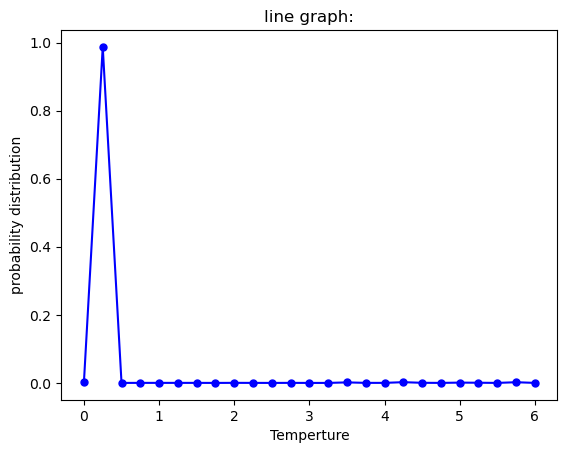

tensor(0.2500)


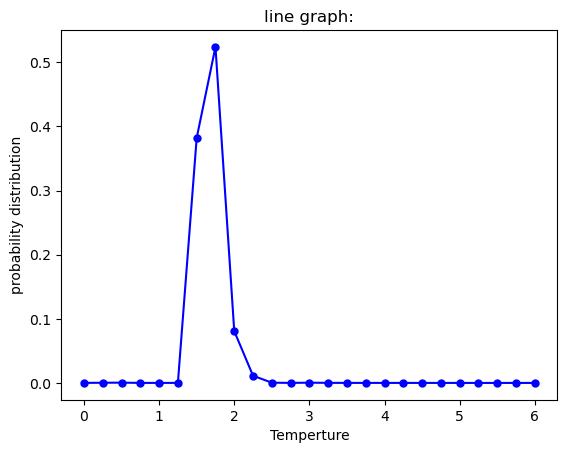

tensor(0.2500)


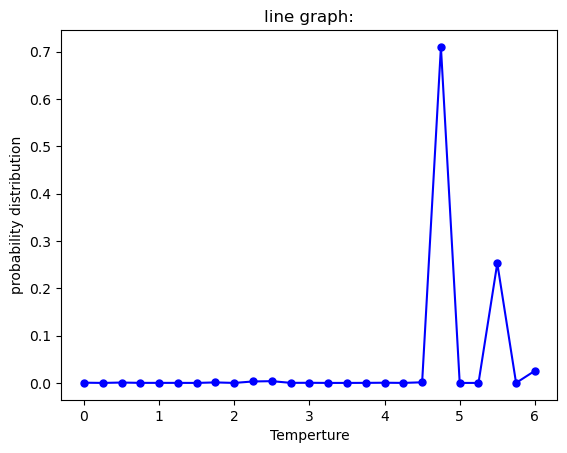

tensor(3.7500)


In [34]:
# データのx軸値
x = [i * 0.25 for i in range(25)]

for n in range(10):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('Temperture')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n]*0.25)


モデルの保存

In [35]:
# params = model.state_dict()
# torch.save(params, "model_L=20.prm")

In [37]:
# # データを保存するディレクトリのパス
# save_dir = "Data"

# # ファイル名
# file_name = "FCNN_L16.prm"

# # フルパスを作成
# full_path = os.path.join(save_dir, file_name)

# # パラメータを保存
# torch.save(file_name, full_path)

In [38]:
torch.save(model.state_dict(), 'data_storage/FCNN_L16.pth')